# DT2470 Audio fingerprint identification system

by Marcos Fernández Carbonell




# 1.Introduction


In this project, a music identification system will be built and tested following the main ideas of the fingerprint techniques that Wang used in the Shazam commercial [1], which are explained in detail in section 7.1 of the book Fundamentals of music processing by Meinard Müller [2].

Audio identification techniques have been widely used within many commercial applications such as broadcast and copyright checking, or added-value services for delivering metadata and other content information [2].

The main goal of this project aims to develop an algorithm to identify where the six queries (Qx.wav) come from in the Kiki and Bouba dataset. The project can be divided in two parts. First, an inverted list system is created from a set of 400 tracks. Second, a query algorithm is implemented to identify where the queries come from.

# 2.Main ideas

Each audio signal can be identified with a fingerprint. This fingerprint is built by strategically finding several points of interest from its time-frequency representation, constructing tuples from the extracted points, and creating hashes to describe the fingerprint of the audio signal.

![fingerprint overview](https://drive.google.com/uc?id=1TPoFzNG16L9k-s_-l2x8e4xzLLC2xqSS)

Setting up the environment

In [4]:
# Install a python library for working with audio files, named pydub
!pip install pydub

from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

root_path_lab03 = 'gdrive/My Drive/KTH/DT2470/Lab_03/data/'
root_path_lab01 = 'gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import time, sys, os, pydub
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

The following function finds key points (anchors) from the time-frequency representation. In order to do so I took a rather naive approach: for each contiguous ΔTxΔF box, find the time and frequency with the largest energy. With default values of ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands.

In [0]:
def locate_anchors(f, t, Zxx, At = 0.1, f_nsegm = 25, fs = 44100):
  t_nsegm = np.floor(t[-1]/At).astype(int) # Get number of time segments
  Af = ((fs/2)/f_nsegm) # Divide the spectrum [0 Fs/2] into 25 bands

  #anchors = np.zeros([f_nsegm,t_nsegm])

  f_max_idx = []
  t_max_idx = []
  for band in range(0,f_nsegm):
    for n in range(0,t_nsegm):
      # Time and freq segment where we look for the max value
      f_segm = (f >= band*Af) & (f < (band+1)*Af)
      t_segm = (t >= n*At) & (t < (n+1)*At)
      t_segm_idx = np.asarray(np.where(t_segm == 1))
      f_segm_idx = np.asarray(np.where(f_segm == 1))

      stft_tmp = np.zeros([np.size(f_segm_idx,1),np.size(t_segm_idx,1)])
      for ti in range(0,t_segm_idx.shape[1]):
        stft_tmp[:,ti] = Zxx[f_segm_idx,t_segm_idx[0,ti]]

      #anchors[band,n] = np.max(stft_tmp)
      ind = np.asarray(np.unravel_index(np.argmax(stft_tmp), stft_tmp.shape))
      f_max_idx.append(f_segm_idx[0,ind[0]])
      t_max_idx.append(t_segm_idx[0,ind[1]])
  f_anchors = np.round(f[f_max_idx],2)
  t_anchors = np.round(t[t_max_idx],2)

  del t_nsegm, Af, f_max_idx, t_max_idx, f_segm, t_segm, t_segm_idx, f_segm_idx, stft_tmp, ind
  return f_anchors, t_anchors

The next function computes hashes and creates the fingerprint from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). For a given anchor, it computes hashes using anchors in a "target zone". The default target zone of an anchor is defined by default as a time-frequency region of 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. A fingerprint looks like $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs.

In [0]:
def compute_hashes(t_anchors, f_anchors):
  time_target_zone = np.array([0.7, 0.7*2])
  freq_target_zone = np.array([2**-0.5, 2**0.5])
  
  fingerprint = []
  for n in range(t_anchors.size):
    t1 = t_anchors[n]
    f1 = f_anchors[n]
    t_lower_limit = t1+time_target_zone[0]
    t_upper_limit = t1+time_target_zone[0]+time_target_zone[1]
    f_lower_limit = f1*freq_target_zone[0]
    f_upper_limit = f1*freq_target_zone[1]

    for m in range(t_anchors.size):
      t2 = t_anchors[m]
      if((t2 >= t_lower_limit) & (t2 < t_upper_limit)): # Check time zone
        f2 = f_anchors[m]
        if((f2 >= f_lower_limit) & (f2 < f_upper_limit)): # Check frequency zone
          # If it is in targuet zone
          fingerprint.append([t1,(f1,f2,round(t2-t1,2))])
  del time_target_zone, freq_target_zone, t1, f1, t_lower_limit, t_upper_limit, f_lower_limit, f_upper_limit, t2, f2
  return np.array(fingerprint)

With the following script, we test that the locate anchors function works properly.

Default configuration

STFT:

*   Window duration: 50 ms
*   Hop size: 10 ms

Locate anchors:
*   At: 100 ms
*   Number of frequency bands: 25

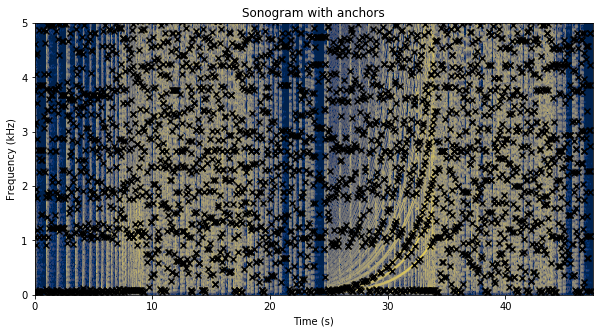

In [5]:
# Load the audio file
kiki_test_path = root_path_lab01 + 'kikibouba_test/kiki/'
kiki_test_files = [kiki_test_path + s for s in sorted(os.listdir(kiki_test_path))]

sound = pydub.AudioSegment.from_file(kiki_test_files[0])
samples = sound.get_array_of_samples() # Return the raw audio data as an array of (numeric) samples
samples = [(ele/2**16.)*2 for ele in samples] # Normalize the 16-bit track, samples is now normalized [-1,1]
fs = sound.frame_rate # Get the sampling frequency

# STFT of the fragment using Hann window of duration 50 ms and hopsize of 10 ms
window_duration = 0.050 # 50 ms
hop_size = 0.010        # 10 ms
zp_factor = 4           # Zeropadding to four times the length of the window.
f, t, Zxx = signal.stft(samples, fs, window='hann',
                        nperseg=window_duration*fs,
                        noverlap=(window_duration-hop_size)*fs,
                        nfft=zp_factor*window_duration*fs) # stft computing
samples_stft_dB = 20*np.log10(np.abs(Zxx)/np.max(np.abs(Zxx)))

# Locate anchors
At = 0.1 # 100 ms
f_nsegm = 25 # 25 bands
f_anchors, t_anchors = locate_anchors(f, t, samples_stft_dB, At, f_nsegm)

# Plot anchors
fig, ax = plt.subplots(figsize=(10, 5))
plt.pcolormesh(t, f/1000, samples_stft_dB, vmin=-80, vmax=0, cmap='cividis')
plt.scatter(t_anchors, f_anchors/1000, c='black', marker="x")
plt.title('Sonogram with anchors')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
ax.set_xlim(left=0, right=np.max(t))
plt.ylim([0,5])
plt.show()

As we can see, a large number of anchors were found after running the above functions. Hence, I decided to tune some parameters in order to reduce computation time.

New configuration

STFT:

*   Window duration: 100 ms
*   Hop size: 50 ms

Locate anchors:
*   At: 700 ms
*   Number of frequency bands: 25

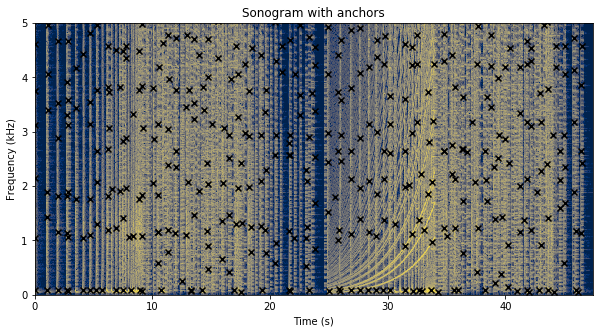

In [6]:
# Load the audio file
kiki_test_path = root_path_lab01 + 'kikibouba_test/kiki/'
kiki_test_files = [kiki_test_path + s for s in sorted(os.listdir(kiki_test_path))]

sound = pydub.AudioSegment.from_file(kiki_test_files[0])
samples = sound.get_array_of_samples() # Return the raw audio data as an array of (numeric) samples
samples = [(ele/2**16.)*2 for ele in samples] # Normalize the 16-bit track, samples is now normalized [-1,1]
fs = sound.frame_rate # Get the sampling frequency

# STFT of the fragment using Hann window of duration 50 ms and hopsize of 10 ms
window_duration = 0.100 # 100 ms
hop_size = 0.050        # 50 ms
zp_factor = 4           # Zeropadding to four times the length of the window.
f, t, Zxx = signal.stft(samples, fs, window='hann',
                        nperseg=window_duration*fs,
                        noverlap=(window_duration-hop_size)*fs,
                        nfft=zp_factor*window_duration*fs) # stft computing
samples_stft_dB = 20*np.log10(np.abs(Zxx)/np.max(np.abs(Zxx)))

# Locate anchors
At = 0.7 # 700 ms
f_nsegm = 25 # 25 bands
f_anchors, t_anchors = locate_anchors(f, t, samples_stft_dB, At, f_nsegm)

# Plot anchors
fig, ax = plt.subplots(figsize=(10, 5))
plt.pcolormesh(t, f/1000, samples_stft_dB, vmin=-80, vmax=0, cmap='cividis')
plt.scatter(t_anchors, f_anchors/1000, c='black', marker="x")
plt.title('Sonogram with anchors')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
ax.set_xlim(left=0, right=np.max(t))
plt.ylim([0,5])
plt.show()

It can be seen in the figure above that the number of anchors has decreased after tunnig the STFT parameters. Thus, now the inverted lists will be built faster than before.

With this new configuration I created a function that builds a fingerprint from a given audio file.
STFT:

*   Window duration: 100 ms
*   Hop size: 50 ms

Locate anchors:
*   At: 700 ms
*   Number of frequency bands: 25

Compute hashes:
*   Time targuet zone: [ $t_1+700$ ms,  $t_1+700$ ms $ + 1400$ ms ]
*   Frequency targuet zone: [ $f_12^{-0.5}$, $f_12^{0.5}$ ]

In [0]:
def fingerprint_from_audiofile(filepath):
  # Load the audio file
  #t_1_performance = time.time()
  sound = pydub.AudioSegment.from_file(filepath)
  samples = sound.get_array_of_samples() # Return the raw audio data as an array of (numeric) samples
  samples = [(ele/2**16.)*2 for ele in samples] # Normalize the 16-bit track, samples is now normalized [-1,1]
  fs = sound.frame_rate # Get the sampling frequency
  #t_2_performance = time.time()
  #print('Load time: ' + str(t_2_performance - t_1_performance))

  # STFT of the fragment using Hann window of duration 50 ms and hopsize of 10 ms
  window_duration = 0.100 # 50 ms
  hop_size = 0.050        # 10 ms
  zp_factor = 4           # Zeropadding to four times the length of the window.
  f, t, Zxx = signal.stft(samples, fs, window='hann',
                          nperseg=window_duration*fs,
                          noverlap=(window_duration-hop_size)*fs,
                          nfft=zp_factor*window_duration*fs) # stft computing
  samples_stft_dB = 20*np.log10(np.abs(Zxx)/np.max(np.abs(Zxx)))
  #t_3_performance = time.time()
  #print('STFT time: ' + str(t_3_performance - t_2_performance))

  # Locate anchors
  At = 0.7 # 700 ms
  f_nsegm = 25 # 25 bands
  #t_4_performance = time.time()
  f_anchors, t_anchors = locate_anchors(f, t, samples_stft_dB, At, f_nsegm)
  #t_5_performance = time.time()
  #print('Anchors time: ' + str(t_5_performance - t_4_performance))
  F = compute_hashes(t_anchors, f_anchors) # Get fingerprint
  #t_6_performance = time.time()
  #print('Fingerprint time: ' + str(t_6_performance - t_5_performance))
  del sound, samples, fs, window_duration, hop_size, zp_factor, f, t, Zxx, samples_stft_dB, At, f_nsegm, f_anchors, t_anchors
  return F

# 3.Inverted lists

Comparing all the hashes in a fingerprint query against all hashes in the database it is not feasible for large databases. Thus, the following inverted index technique was utilized

First, fingerprints are calculated for each track in the database. Second, an inverted list is built from each fingerprint. Third, all the inverted lists are concatenated into a global list of inverted lists.

The following function builds an inverted list from a fingerprint.

In [0]:
from numpy import unique, array, where, delete
def build_inverted_list(F1):
  key_hashes = unique(F1[:,1]) # Equivalent to keywords
  inverted_list = {k: [] for k in key_hashes}
  F1_time = array(F1[:,0])     # Get t1 from fingerprint (Fingerprint 1)
  F1_hash = array(list(F1[:,1]))     # Get t1 from hash (Fingerprint 1)

  for kh in key_hashes:
    idx = where((F1_hash == kh).all(axis=1))
    inverted_list[kh].append(list(F1_time[idx]))
    delete(F1_time,idx,axis=0)
    delete(F1_hash,idx,axis=0)
  return inverted_list

The following script builds the inverted lists for the kiki test set.

In [0]:
# Inverted lists (KIKI TEST DB)
kiki_test_path = root_path_lab01 + 'kikibouba_test/kiki/'
kiki_test_files = [kiki_test_path + s for s in sorted(os.listdir(kiki_test_path))]

inverted_lists = [] # List of inverted lists (dictionaries)
inverted_lists_ref = []  # File reference
time1 = time.time()

for i in tqdm(kiki_test_files):
#for i in tqdm(kiki_test_files[0:1]):
  F_tmp = fingerprint_from_audiofile(i)
  inverted_list_tmp = build_inverted_list(F_tmp)
  inverted_lists.append(inverted_list_tmp)
  inverted_lists_ref.append(i)
  del F_tmp, inverted_list_tmp

print('Computation time: ' +str(time.time()-time1))

100%|██████████| 100/100 [1:11:36<00:00, 40.31s/it]

Computation time: 4296.320566415787


The progress bar above shows that building the inverted lists takes around an hour for 100 tracks. 

The following script stores the kiki test inverted lists to a .npz file.

In [0]:
 # Save in a npz file the inverted lists (KIKI TEST DB)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_kiki_test_db', inverted_lists)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_ref_kiki_test_db', inverted_lists_ref)

The following script builds the inverted lists for the kiki training set.

In [0]:
# Inverted lists (KIKI TRAIN DB)
kiki_train_path = root_path_lab01 + 'kikibouba_train/kiki/'
kiki_train_files = [kiki_train_path + s for s in sorted(os.listdir(kiki_train_path))]

inverted_lists = [] # List of inverted lists (dictionaries)
inverted_lists_ref = []  # File reference
time1 = time.time()
for i in tqdm(kiki_train_files):
#for i in tqdm(kiki_train_files[0:1]):
  F_tmp = fingerprint_from_audiofile(i)
  inverted_list_tmp = build_inverted_list(F_tmp)
  inverted_lists.append(inverted_list_tmp)
  inverted_lists_ref.append(i)
  del F_tmp, inverted_list_tmp
print('Computation time: ' +str(time.time()-time1))

100%|██████████| 100/100 [54:46<00:00, 41.62s/it]

Computation time: 3286.670918941498


The following script stores the kiki training inverted lists to a .npz file.

In [0]:
# Save in a npz file the inverted lists (KIKI TRAIN DB)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_kiki_train_db', inverted_lists)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_ref_kiki_train_db', inverted_lists_ref)

The following script builds the inverted lists for the bouba test set.

In [0]:
# Inverted lists (BOUBA TEST DB)
bouba_test_path = root_path_lab01 + 'kikibouba_test/bouba/'
bouba_test_files = [bouba_test_path + s for s in sorted(os.listdir(bouba_test_path))]

inverted_lists = [] # List of inverted lists (dictionaries)
inverted_lists_ref = []  # File reference
time1 = time.time()
for i in tqdm(bouba_test_files):
#for i in tqdm(bouba_test_files[0:1]):
  F_tmp = fingerprint_from_audiofile(i)
  inverted_list_tmp = build_inverted_list(F_tmp)
  inverted_lists.append(inverted_list_tmp)
  inverted_lists_ref.append(i)
  del F_tmp, inverted_list_tmp
print('Computation time: ' +str(time.time()-time1))

100%|██████████| 100/100 [1:14:16<00:00, 40.62s/it]

Computation time: 4456.308615446091


The following script stores the bouba test inverted lists to a .npz file.

In [0]:
 # Save in a npz file the inverted lists (BOUBA TEST DB)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_bouba_test_db', inverted_lists)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_ref_bouba_test_db', inverted_lists_ref)

The following script builds the inverted lists for the bouba training set.

In [0]:
# Inverted lists (BOUBA TRAIN DB)
bouba_train_path = root_path_lab01 + 'kikibouba_train/bouba/'
bouba_train_files = [bouba_train_path + s for s in sorted(os.listdir(bouba_train_path))]

inverted_lists = [] # List of inverted lists (dictionaries)
inverted_lists_ref = []  # File reference
time1 = time.time()
for i in tqdm(bouba_train_files):
#for i in tqdm(bouba_train_files[0:1]):
  F_tmp = fingerprint_from_audiofile(i)
  inverted_list_tmp = build_inverted_list(F_tmp)
  inverted_lists.append(inverted_list_tmp)
  inverted_lists_ref.append(i)
  del F_tmp, inverted_list_tmp
print('Computation time: ' +str(time.time()-time1))

100%|██████████| 100/100 [1:13:41<00:00, 50.43s/it]

Computation time: 4421.807629585266


The following script stores the bouba training inverted lists to a .npz file.

In [0]:
 # Save in a npz file the inverted lists (BOUBA TRAIN DB)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_bouba_train_db', inverted_lists)
np.savez_compressed(root_path_lab03 + 'out/inverted_lists_ref_bouba_train_db', inverted_lists_ref)

This script concatenates all inverted lists to create a single database. In `IL` there is a list of inverted lists and in `IL_ID` there is a list of the file path of each inverted list.



In [0]:
# Load from inverted lists from npz files and concatenate them
# Load Kiki test inverted lists
arr = np.load(root_path_lab03 + 'out/inverted_lists_kiki_test_db.npz', allow_pickle = 1)
IL_ktest = arr['arr_0']
arr = np.load(root_path_lab03 + 'out/inverted_lists_ref_kiki_test_db.npz', allow_pickle = 1)
IL_ref_ktest = arr['arr_0']

# Load Kiki train inverted lists
arr = np.load(root_path_lab03 + 'out/inverted_lists_kiki_train_db.npz', allow_pickle = 1)
IL_ktrain = arr['arr_0']
arr = np.load(root_path_lab03 + 'out/inverted_lists_ref_kiki_train_db.npz', allow_pickle = 1)
IL_ref_ktrain = arr['arr_0']

# Load Bouba test inverted lists
arr = np.load(root_path_lab03 + 'out/inverted_lists_bouba_test_db.npz', allow_pickle = 1)
IL_btest = arr['arr_0']
arr = np.load(root_path_lab03 + 'out/inverted_lists_ref_bouba_test_db.npz', allow_pickle = 1)
IL_ref_btest = arr['arr_0']

# Load Bouba train inverted lists
arr = np.load(root_path_lab03 + 'out/inverted_lists_bouba_train_db.npz', allow_pickle = 1)
IL_btrain = arr['arr_0']
arr = np.load(root_path_lab03 + 'out/inverted_lists_ref_bouba_train_db.npz', allow_pickle = 1)
IL_ref_btrain = arr['arr_0']
del arr

# Concatenate 
IL = np.concatenate((IL_ktest,IL_ktrain,IL_btest,IL_btrain))  # Inverted lists of the 400 tracks 
IL_id = np.concatenate((IL_ref_ktest,IL_ref_ktrain,IL_ref_btest,IL_ref_btrain))  # ID of the inverted list

# 4.Querying
In the next two subsections two different identification approaches were implemented and tested.

## 4.1.Approach 1 + Results

This approach identifies the track with the highest number of hash matches as the file source of the query fragment.

In [0]:
def identify_track(F_q,IL,IL_id):
  hashes = F_q[:,1]
  track_bins = np.zeros(len(IL))
  for track in range(0,len(IL)):
    IL_tmp = IL[track].copy()
    for h in hashes:
      l = IL_tmp.get(h)  # Time-stamps with that hash 
      if l != None:
        track_bins[track] += len(l[0])
  max_count = np.max(track_bins)
  identified_file = IL_id[np.where(track_bins == max_count)][0]
  return identified_file, track_bins

In [0]:
def plot_results_approach1(identified_track,track_bins,query_number = '?'):
  max_count = int(np.max(track_bins))
  print('Q' + str(query_number) +' ('+str(max_count)+' matches were found) comes from: '+ identified_track)
  plt.figure(figsize=(10, 5))
  plt.bar(range(0,len(track_bins)),track_bins)
  plt.title('Q' + str(query_number))
  plt.xlabel('Tracks')
  plt.ylabel('Matches')
  plt.plot()


This script pushes the query files throughout the whole algorithm and plot the results for the six queries.



Q1 (29 matches were found) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/bouba/bouba_0131.m4a
Q2 (25 matches were found) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_train/bouba/bouba_0004.m4a
Q3 (200 matches were found) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/kiki/kiki_0199.m4a
Q4 (300 matches were found) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_train/kiki/kiki_0043.m4a
Q5 (15 matches were found) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_train/bouba/bouba_0002.m4a
Q6 (6 matches were found) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/kiki/kiki_0105.m4a


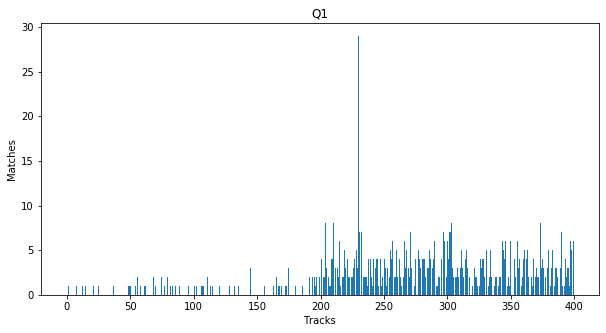

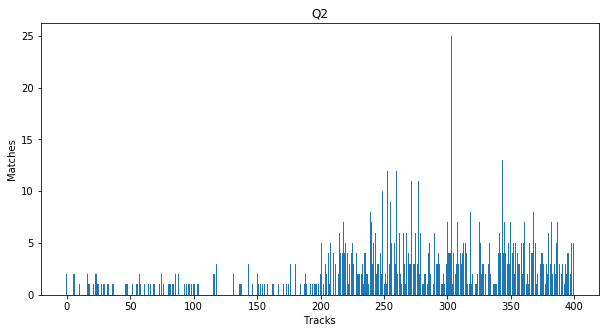

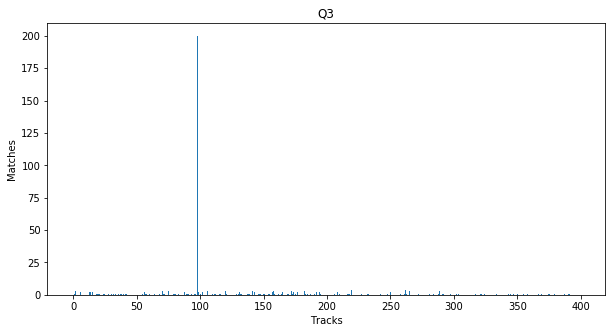

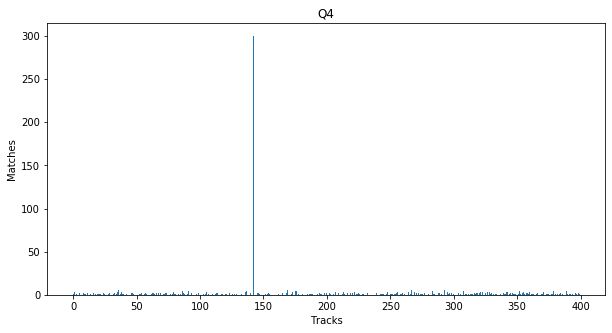

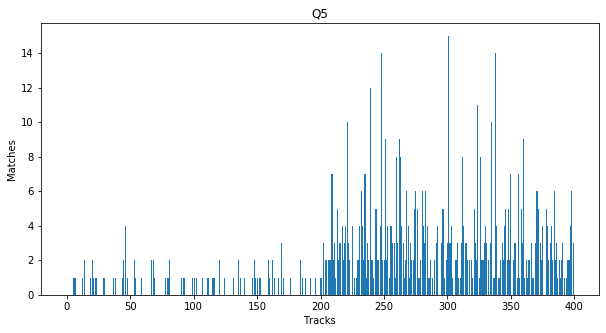

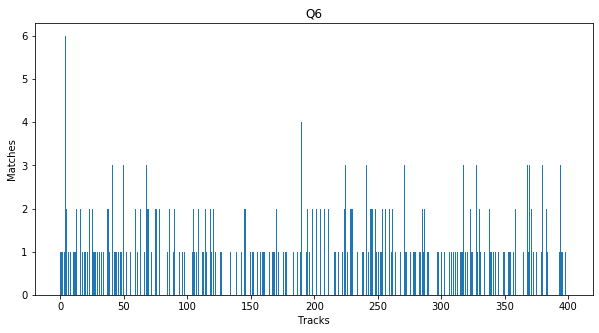

In [37]:
# Identify where Q1 come from
F_q1 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q1.wav') # Compute fingerprint for Q1
identified_track_q1, track_bins_q1 = identify_track(F_q1,IL,IL_id)    # Identify track from fingerprint Q1
plot_results_approach1(identified_track_q1,track_bins_q1,1)           # Plot results identification Q1

# Identify where Q2 come from
F_q2 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q2.wav') # Compute fingerprint for Q2
identified_track_q2, track_bins_q2 = identify_track(F_q2,IL,IL_id)    # Identify track from fingerprint Q2
plot_results_approach1(identified_track_q2,track_bins_q2,2)           # Plot results identification Q2

# Identify where Q3 come from
F_q3 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q3.wav') # Compute fingerprint for Q3
identified_track_q3, track_bins_q3 = identify_track(F_q3,IL,IL_id)    # Identify track from fingerprint Q3
plot_results_approach1(identified_track_q3,track_bins_q3,3)           # Plot results identification Q3

# Identify where Q4 come from
F_q4 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q4.wav') # Compute fingerprint for Q4
identified_track_q4, track_bins_q4 = identify_track(F_q4,IL,IL_id)    # Identify track from fingerprint Q4
plot_results_approach1(identified_track_q4,track_bins_q4,4)           # Plot results identification Q4

# Identify where Q5 come from
F_q5 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q5.wav') # Compute fingerprint for Q5
identified_track_q5, track_bins_q5 = identify_track(F_q5,IL,IL_id)    # Identify track from fingerprint Q5
plot_results_approach1(identified_track_q5,track_bins_q5,5)           # Plot results identification Q5

# Identify where Q6 come from
F_q6 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q6.wav') # Compute fingerprint for Q6
identified_track_q6, track_bins_q6 = identify_track(F_q6,IL,IL_id)    # Identify track from fingerprint Q6
plot_results_approach1(identified_track_q6,track_bins_q6,6)           # Plot results identification Q6

The next table summarizes the results obtained.

Query | Predicted | True File
--- | --- | ---
Q1 | bouba_0131 | bouba_0131
Q2 | bouba_0004 | ?
Q3 | kiki_0199 | kiki_0199
Q4 | kiki_0043 | kiki_0043
Q5 | bouba_0002 | ?
Q6 | kiki_0105 | ?

The results were checked by listening to both audio files and seeing their waveform using Sonic Visualizer.

Contrary to expectations, the implemented system has been able to correctly identify only three of the query files. From the histograms above we can note that the system found several matches for those tracks that were correctly predicted, whereas, for the other ones, the number of matches was more uniform.

## 4.2.Approach 2 + Results

This approach identifies the track with the highest number of offset hash matches as the file source of the query fragment. In order to do so, the differences between the timestamps of the fingerprint query and the inverted list were calculated and counted.

In [0]:
import collections

def identify_track_and_offset(F_q,IL,IL_id):
  time_stamp_q = F_q[:,0]                                             # Time-stamps fingerprint query
  hashes = F_q[:,1]                                                   # Hashes fingerprint query
  track_most_common_offset_counter = np.zeros(len(IL))                # Initialize counter
  track_offset = np.zeros(len(IL))                                    # Initialize offset bins
  
  for track in range(len(IL)):                                        # For each track do...
    IL_tmp = IL[track].copy()                                         # Copy the dictionary (inverted list)
    m_tmp = []                                                        # Initialize m (m=l-n)
    for i in range(len(F_q)):                                         # For each hash of the fingerprint query do...
      l = IL_tmp.get(hashes[i])                                       # Time-stamps with that hash
      if l != None:                                                   # If hash matches
        n = time_stamp_q[i]                                           # Get n value from fingerprint query
        m_tmp = m_tmp + (np.round((l[0] - n),2)).tolist()             # Calculate m (Difference between the timestamps of the fingerprint query and the inverted list)
    if(m_tmp != []):                                                  # If it isn't empty then...
      counter_m_tmp = collections.Counter(m_tmp)                      # Compute histogram
      most_common_tmp = counter_m_tmp.most_common(1)                  # Pick the most common one
      track_most_common_offset_counter[track] = most_common_tmp[0][1] # Add the number of occurrences of the most common one to the counter
      track_offset[track] = most_common_tmp[0][0]                     # Save the offset value of the most common one       
  
  identified_file = IL_id[np.where(track_most_common_offset_counter==np.max(track_most_common_offset_counter))][0]  # Find the track with the highest number of occurrences
  offset = track_offset[np.where(track_most_common_offset_counter==np.max(track_most_common_offset_counter))][0]    # Get the offset values with the highest number of occurrences
  return identified_file, offset, track_most_common_offset_counter

In [0]:
def plot_results_approach2(identified_track,track_bins,offset,query_number = '?'):
  max_count = int(np.max(track_bins))
  print('Q' + str(query_number) +' ('+str(max_count)+' matches were found with an offset of '+ str(offset) +' sec.) comes from: '+ identified_track)
  plt.figure(figsize=(10, 5))
  plt.bar(range(0,len(track_bins)),track_bins)
  plt.title('Q' + str(query_number))
  plt.xlabel('Tracks')
  plt.ylabel('Matches')
  plt.plot()

This script pushes the query files throughout the whole algorithm and plot the results for the 6 queries.

Q1 (15 matches were found with an offset of 26.35 sec.) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/bouba/bouba_0131.m4a
Q2 (15 matches were found with an offset of 4.15 sec.) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/bouba/bouba_0178.m4a
Q3 (196 matches were found with an offset of 16.8 sec.) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/kiki/kiki_0199.m4a
Q4 (294 matches were found with an offset of 16.75 sec.) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_train/kiki/kiki_0043.m4a
Q5 (3 matches were found with an offset of 43.45 sec.) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/bouba/bouba_0181.m4a
Q6 (2 matches were found with an offset of 26.35 sec.) comes from: gdrive/My Drive/KTH/DT2470/Lab_01/KikiBoubadata/kikibouba_test/kiki/kiki_0105.m4a


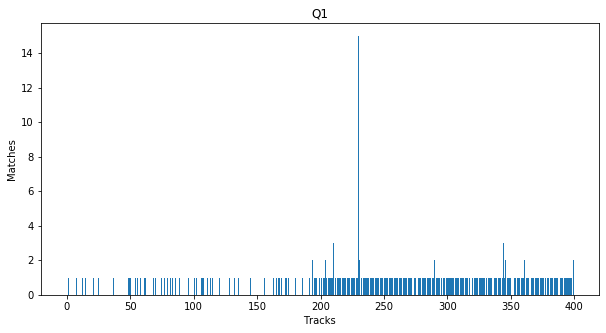

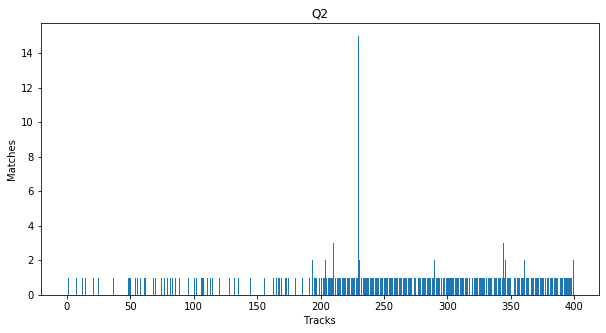

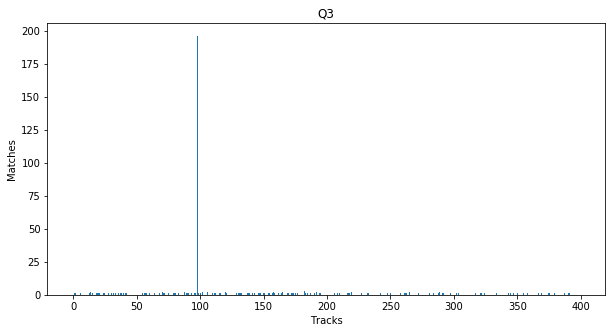

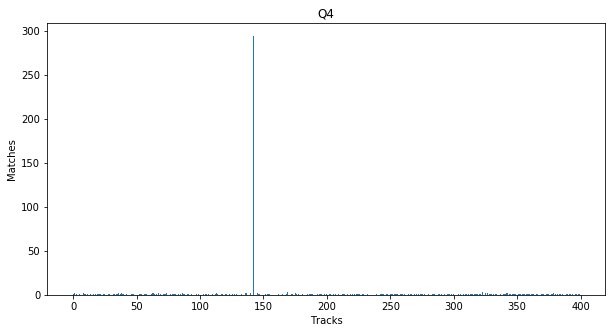

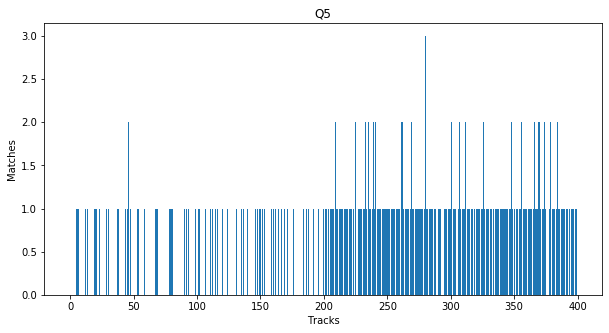

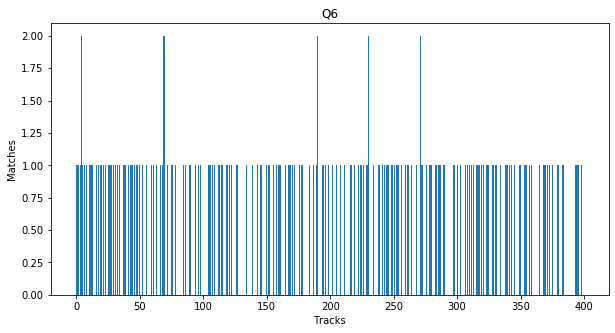

In [41]:
# Identify where Q1 comes from
F_q1 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q1.wav')                     # Compute fingerprint for Q1
identified_track_q1, offset_q1, track_bins_q1 = identify_track_and_offset(F_q1,IL,IL_id)  # Identify track from fingerprint Q1
plot_results_approach2(identified_track_q1,track_bins_q1,offset_q1,1)                     # Plot results identification Q1

# Identify where Q2 comes from
F_q2 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q2.wav')                     # Compute fingerprint for Q2
identified_track_q2, offset_q2, track_bins_q2 = identify_track_and_offset(F_q2,IL,IL_id)  # Identify track from fingerprint Q2
plot_results_approach2(identified_track_q2,track_bins_q1,offset_q2,2)                     # Plot results identification Q2

# Identify where Q3 comes from
F_q3 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q3.wav')                     # Compute fingerprint for Q3
identified_track_q3, offset_q3, track_bins_q3 = identify_track_and_offset(F_q3,IL,IL_id)  # Identify track from fingerprint Q3
plot_results_approach2(identified_track_q3,track_bins_q3,offset_q3,3)                     # Plot results identification Q3

# Identify where Q4 comes from
F_q4 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q4.wav')                     # Compute fingerprint for Q4
identified_track_q4, offset_q4, track_bins_q4 = identify_track_and_offset(F_q4,IL,IL_id)  # Identify track from fingerprint Q4
plot_results_approach2(identified_track_q4,track_bins_q4,offset_q4,4)                     # Plot results identification Q4

# Identify where Q5 comes from
F_q5 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q5.wav')                     # Compute fingerprint for Q5
identified_track_q5, offset_q5, track_bins_q5 = identify_track_and_offset(F_q5,IL,IL_id)  # Identify track from fingerprint Q5
plot_results_approach2(identified_track_q5,track_bins_q5,offset_q5,5)                     # Plot results identification Q5

# Identify where Q6 comes from
F_q6 = fingerprint_from_audiofile(root_path_lab03 + 'queries/Q6.wav')                     # Compute fingerprint for Q6
identified_track_q6, offset_q6, track_bins_q6 = identify_track_and_offset(F_q6,IL,IL_id)  # Identify track from fingerprint Q6
plot_results_approach2(identified_track_q6,track_bins_q6,offset_q1,6)                     # Plot results identification Q6


The next table summarizes the results obtained.

Query | Predicted (Offset) | True File
--- | --- | ---
Q1 | bouba_0131 (26.35 sec.) | bouba_0131
Q2 | bouba_0178 (4.15 sec.) | ?
Q3 | kiki_0199 (16.8 sec.) | kiki_0199
Q4 | kiki_0043 (16.75 sec.) | kiki_0043
Q5 | bouba_0181 (43.45 sec.) | ?
Q6 | kiki_0105 (26.35 sec.) | ?

The results were checked by listening to both audio files and seeing their waveform using Sonic Visualizer.

Again, with this new approach, the system has just been able to identify three of the six queries. However, with this new method, we also know the proper time offset of the matching position within the predicted song.

# 5.Discussion and Conculsion

The results obtained were below expectations, but this might depend on the values chosen for the fingerprint system. Furthermore, it was not easy to determine which values to choose, since building the inverted file system takes a lot of computation time. These disappointing findings show that there is certainly room for improvement and encourages me to keep trying to solve this problem. Other approaches could change the way inverted index file were built.

On the other hand, in this project I have been able to understand and develop a music identification system based on spectral peaks, create an inverted index file and improve my Python knowledge.

# 6.References

[1] A. Wang, “An industrial-strength audio search  algo-rithm,” inInternational Society for Music InformationRetrieval Conference (ISMIR), Baltimore,  Maryland, USA, 2003, pp. 7–13.

[2] M. Müller, Fundamentals of Music  Processing, Springer, 2015.